In [1]:
import os
import sys
import gzip
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline

In [2]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf');

font = matplotlib.font_manager.FontProperties(fname='/System/Library/Fonts/Supplemental/Avenir.ttf')

In [3]:
plt.rcParams.update({'text.usetex': True,
                        'font.family': "sans-serif",
                        'text.latex.preamble': r"\usepackage{amsmath}"})

In [4]:
# downloading simulation results:
# see ../simulations

N = 1e6
regime = 'r'
rs = np.load('../simulations/out/%s_rs.npy' % regime) # loading R values

In [ ]:
# need to first process raw trajectories – this takes some time! 
# consider skipping this step and loading processed trajectories instead if they exist


param_idx = 20

filename = os.path.join('../simulations/out', 'output_%s_%d.txt.gz' % (regime,param_idx))
file = gzip.GzipFile(filename,"r")
f11s = []
f10s = []
f01s = []

for line in file:

    if line.startswith(b'//'):
        continue
    items = line.split()

    f11 = float(items[0])
    f10 = float(items[1])
    f01 = float(items[2])

    f11s.append(f11)
    f10s.append(f10)
    f01s.append(f01)

file.close()

f11s = np.array(f11s)
f10s = np.array(f10s)
f01s = np.array(f01s)
f00s = 1 - f11s - f10s - f01s
fAs = f11s + f10s
fBs = f11s + f01s

all_fs = np.stack((f11s, f10s, f01s), axis=-1)
np.save(os.path.join('../simulations/out', 'fs_%s_%d'%(regime,param_idx)), all_fs)

In [ ]:
# alternatively, can load already processed trajectories
# feel free to skip this step too

# large NRf_0 first:
param_idx = 20 # alo use 12, 4
r = rs[param_idx]

all_fs = np.load(os.path.join('../simulations/out', 'fs_%s_%d.npy'%(regime,param_idx)))
f11s = all_fs[:, 0]
f10s = all_fs[:, 1]
f01s = all_fs[:, 2]
f00s = 1-f11s-f10s-f01s
fAs = f11s+f10s
fBs = f11s+f01s

# freq ranges
f_lims = [(0.0012, 0.0018), (0.004, 0.0056), (0.012, 0.018), (0.04, 0.056)]

for i, (f_min, f_max) in enumerate(f_lims):
    rho = 2 * N * r * np.sqrt(f_min * f_max)
    nrf2 = N * r * f_min * f_max
    mask = (fAs >= f_min) & (fAs <= f_max) & (fBs >= f_min) & (fBs <= f_max)
    lambdas = (f11s[mask]*f10s[mask]*f01s[mask]*f00s[mask]) / np.square(fAs[mask] * fBs[mask]*(1-fAs[mask])*(1-fBs[mask]))
    #print(rho, nrf2, lambdas.mean())
    np.save('../simulations/out/lambda2_distr_rho=' + '{:.3f}'.format(rho) + '_nrf0^2=' + '{:.3f}'.format(nrf2), lambdas)
    np.save('../simulations/out/lambda2_distr_f_min=' + '{:.4f}'.format(f_min) + '_f_max=' + '{:.4f}'.format(f_max) + '_r=' + '{:.8f}'.format(r), lambdas)

In [5]:
# downloading lambda distributions computed above

lambda2_large_rho_large_nrff = np.load('../simulations/out/lambda2_distr_f_min=0.0400_f_max=0.0560_r=0.05623413.npy')
lambda2_large_rho_nrff_1 = np.load('../simulations/out/lambda2_distr_f_min=0.0040_f_max=0.0056_r=0.05623413.npy')
lambda2_large_rho_small_nrff = np.load('../simulations/out/lambda2_distr_f_min=0.0012_f_max=0.0018_r=0.05623413.npy')
lambda2_small_rho_small_nrff = np.load('../simulations/out/lambda2_distr_f_min=0.0120_f_max=0.0180_r=0.00000562.npy')

In [6]:
# downloading pre-processed simulation results
# see code used to compute these in ./fig6B_preprocess_data.ipynb

four_gamete_f0s = np.load('../simulations/out/f0s_sim.npy')
four_gamete_prob = np.load('../simulations/out/4g_prob_sim.npy')

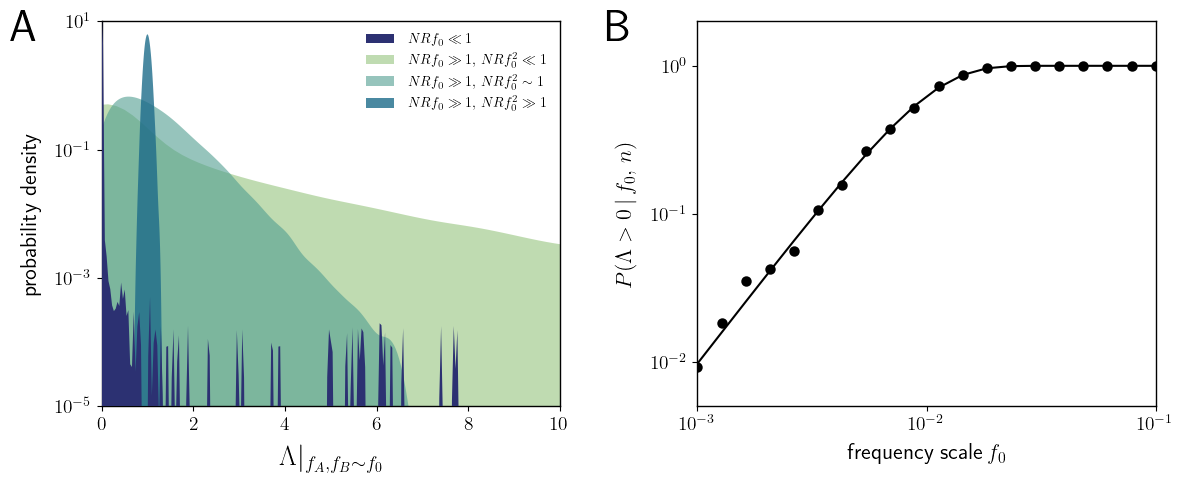

In [7]:
matplotlib.rcParams['axes.linewidth'] = 1

fig = plt.figure(figsize=(13.6, 5))

grid = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1, 1], wspace=0.3,
                         height_ratios=[1], hspace=0.1)

cmap = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=1, vmax=4),cmap=sns.color_palette("crest", as_cmap=True))
grey = '#a1a1a1' 
w = 1.5 # linewidth

for c in range(2):
    
    plt.subplot(grid[c // 2, c % 2])
    
    # left panel
    if c == 0: 
        
        ax = plt.gca()
        
        rhos = np.logspace(-4.5, 4.5, int(1e2))
        
        sns.kdeplot(lambda2_small_rho_small_nrff, bw_adjust=2.5, fill=True, alpha=1, linewidth=0, 
            color=matplotlib.colors.rgb2hex(cmap.to_rgba(4)), zorder=4, label=r"$NRf_0 \ll 1$")
        sns.kdeplot(lambda2_large_rho_small_nrff, bw_adjust=2.5, fill=True, alpha=0.7, linewidth=0, 
            color=matplotlib.colors.rgb2hex(cmap.to_rgba(1)), zorder=1, label=r"$NRf_0 \gg 1, \, NRf_0^2 \ll 1$")
        sns.kdeplot(lambda2_large_rho_nrff_1, bw_adjust=2.5, fill=True, alpha=0.6, linewidth=0, 
            color=matplotlib.colors.rgb2hex(cmap.to_rgba(2)), zorder=2, label=r"$NRf_0 \gg 1, \, NRf_0^2 \sim 1$")
        sns.kdeplot(lambda2_large_rho_large_nrff, bw_adjust=2.5, fill=True, alpha=0.8, linewidth=0, 
            color=matplotlib.colors.rgb2hex(cmap.to_rgba(3)), zorder=3, label=r"$NRf_0 \gg 1, \, NRf_0^2 \gg 1$")

        plt.yscale('log')
        plt.minorticks_off()
        plt.tick_params(axis='both', labelsize=14)

        plt.xticks([0, 2, 4, 6, 8, 10], 
                   [r"$0$", r"$2$", r"$4$", r"$6$", r"$8$", r"$10$"])
        plt.yticks([1e-5, 1e-3, 1e-1, 1e1], 
                   ['$10^{-5}$', '$10^{-3}$', '$10^{-1}$', '$10^{1}$'])

        plt.xlim(0, 10)
        plt.ylim(1e-5, 1e1)

        plt.ylabel(r"$\text{probability density}$", fontsize=16, labelpad=10);
        plt.xlabel(r"$\Lambda\vert_{f_A, f_B \sim f_0}$", fontsize=20, labelpad=8);  

        plt.legend(frameon=False, fontsize=10, loc='upper right', handletextpad=1);
        
        plt.text(-0.2, 0.95, 'A', fontsize=32, fontweight='black', transform=ax.transAxes)
        
        
    # right panel    
    if c == 1:
        
        ax = plt.gca()
        
        N = 1e6
        r = 0.1
        n = 10000
        
        # theory curve; see eq. in the main text
        alpha = 2 * N * r * four_gamete_f0s**2
        beta = 2 * N * r
        probs = 1 - np.power(beta / (beta + n), alpha)
        
        plt.plot(four_gamete_f0s, probs, linewidth=w, c='black')
        plt.scatter(four_gamete_f0s, four_gamete_prob, linewidth=w, c='black')
        
        plt.xscale('log')
        plt.yscale('log')
        plt.minorticks_off()
        
        plt.tick_params(axis='both', labelsize=14)

        plt.xticks([1e-3, 1e-2, 1e-1], 
                   ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'])
        plt.yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1], 
                   ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'])

        plt.xlim(1e-3, 1e-1)
        plt.ylim(0.5e-2, 0.2e1)

        plt.ylabel(r"$P(\Lambda>0\,|\,f_0, \, n)$", fontsize=16, labelpad=10);
        plt.xlabel(r"$\text{frequency scale}\,f_0$", fontsize=16, labelpad=8);  

        plt.text(-0.2, 0.95, 'B', fontsize=32, fontweight='black', transform=ax.transAxes)
        
        
plt.savefig('fig6.pdf',dpi=600,bbox_inches='tight') 